## Get all data

In [34]:
import os
import io

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.errors import HttpError

In [38]:
def obtain_drive_credentials(scope : list, token_path : str, credentials_path : str) -> Credentials:
    '''Creates or refresh access token for the Google Drive API.

    Args:
        scope: Accesses to grant.
        token_path: Path to the token.json file.
        credentials_path: Path to the credentials.json file.

    Returns:
        google.oauth2.credentials.Credentials: The refreshed credentials.

    Raises:
        RuntimeError: If credentials are not present.
    '''
    creds = None
    if os.path.exists(TOKEN_PATH):
        creds = Credentials.from_authorized_user_file(TOKEN_PATH, SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            #flow = InstalledAppFlow.from_client_secrets_file(CREDENTIALS_PATH, SCOPES)
            #creds = flow.run_local_server(port=0)
            raise RuntimeError("Can't refresh token.")
        with open(TOKEN_PATH, "w") as token:
                token.write(creds.to_json())
    return creds

In [89]:
def get_objects_from_drive(folderId: str, apiService: any) -> list:
    '''Get objects from specific folder at Google Drive.

    Args:
        folderId: Folder ID from which get the files.
        apiService: A resource object with methods for interacting with the Google Drive API.
    
    Returns:
        out: Returns a list with name and id of the files.
    '''
    results = []
    done = False
    page_token = None
    while done is False:
        page_results = (
            apiService.files()
            .list(pageSize=1000, pageToken=page_token, fields="nextPageToken, files(id, name)", q=f"'{folderId}' in parents")
            .execute()
        )
        results.extend(page_results.get("files", []))
        page_token = page_results.get("nextPageToken", None)
        done = page_token is None
    return results

In [113]:
def download_file_from_drive(fileId: str, outputDir: str, apiService: any) -> None:
    '''Download the specified file to the informed output directory.

    Args:
        fileId: Id of the file to be downloaded.
        outputDir: Directory to which save the file.
        apiService: A resource object with methods for interacting with the Google Drive API.
    '''
    results = apiService.files().get_media(fileId=fileId)
    fh = io.FileIO(outputDir, 'wb')
    downloader = MediaIoBaseDownload(fh, results)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
    print('Download complete.')

In [39]:
SCOPES = ["https://www.googleapis.com/auth/drive.readonly"]
TOKEN_PATH = r"./.env/token.json"
CREDENTIALS_PATH = r"./.env/credentials.json"
creds = obtain_drive_credentials(scope=SCOPES, token_path=TOKEN_PATH, credentials_path=CREDENTIALS_PATH)

In [92]:
service = build("drive", "v3", credentials=creds)
parent_folder = '10GWBZuT_Bm9yX7XG9hQBqnEtexS0ddcn'

classes = get_objects_from_drive("10GWBZuT_Bm9yX7XG9hQBqnEtexS0ddcn", service)
classes

[{'id': '1M2ihrzTWqCJTlDJ2KpYYORBySpha3LVx', 'name': '3'},
 {'id': '1LHx9kdwusqN_WW8LsPRgcxxjmkOjzo4Z', 'name': '0'},
 {'id': '10IIs3HgSlW7fhbhFS2wZdKd5-IB6x_aI', 'name': '4'}]

In [111]:
files_by_class = []
for type in classes:
    files_by_class.append({'class': type['name'], 'files_list': get_objects_from_drive(type['id'], service)})
files_by_class

[{'class': '3',
  'files_list': [{'id': '12h1T3qZ7oWI0bdfY2biJiXc8Q7zF8Kyp',
    'name': 'WELL-00014_20171028180038.csv'},
   {'id': '12viynWFAjoN4M3oodQ7E61-KMKjJ8vSz',
    'name': 'WELL-00014_20171028130000.csv'},
   {'id': '13JemrTIAC5K-o9kDA10XeyB6f7RvDBiR',
    'name': 'WELL-00014_20171028080000.csv'},
   {'id': '134eE_O73-Ce9rdujwA3tHpZqjz-tOU1E',
    'name': 'WELL-00014_20170926170228.csv'},
   {'id': '12_fh9ZYlqpEs1HMX9UXd9o1yex_kEiLH',
    'name': 'WELL-00014_20170926120103.csv'},
   {'id': '12_AiYW16TPK7p37QreE3zd64IOG8d0oq',
    'name': 'WELL-00014_20170926070042.csv'},
   {'id': '12eSlfDT6VanFEl_U_cxKMlXhJi2uHXKF',
    'name': 'WELL-00014_20170926020340.csv'},
   {'id': '13ZDIaE24i3QTyT8jC5vhiKiXgINcB45N',
    'name': 'WELL-00014_20170925210042.csv'},
   {'id': '13FGcKrmqep7m24R4Y7rIwbEuBLVQ3t7P',
    'name': 'WELL-00014_20170925160218.csv'},
   {'id': '12w4GbmLL3YuCVnp4DiD6dmHhGd-oSNS7',
    'name': 'WELL-00014_20170925110124.csv'},
   {'id': '136HIHQpYwHm63RpZZjdCbHgM4TsZ

In [117]:
download_file_from_drive("12h1T3qZ7oWI0bdfY2biJiXc8Q7zF8Kyp", "./data/test.csv", service)

Download complete.


In [126]:
files_by_class[0].get("files_list")[0]

{'id': '12h1T3qZ7oWI0bdfY2biJiXc8Q7zF8Kyp',
 'name': 'WELL-00014_20171028180038.csv'}

In [127]:
for obj in files_by_class:
    if obj["class"] in ['0', '4']:
        class_type, files_count = obj["class"], len(obj["files_list"])
        count = 1
        print(f"Started downloading process for the '{class_type}' class.")
        for file in obj["files_list"]:
            print(f"Downloading {count}/{files_count}...")
            download_file_from_drive(file['id'], f"./data/{class_type}/{file['name']}", service)
            count+=1

Started downloading process for the '0' class.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Download complete.
Dow

## Trainning section

### Library and file imports 

In [128]:
import glob
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score

In [129]:
path_to_normal_operation_files = r"./data/0"
path_to_flow_instability_files = r"./data/4"

all_normal_operation_files = glob.glob(os.path.join(path_to_normal_operation_files, "*.csv"))
all_flow_instability_files = glob.glob(os.path.join(path_to_flow_instability_files, "*.csv"))

In [130]:
all_normal_operation_files[0]

'./data/0\\WELL-00001_20170201020207.csv'

### Base samples

In [131]:
list_files = []
for filename in all_normal_operation_files:
    df_normal = pd.read_csv(filename, index_col=None, header=0)
    list_files.append(df_normal)

normal_frame = pd.concat(list_files, axis=0)
del list_files, df_normal
normal_frame.head(3)

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
0,2017-02-01 02:02:07.000000,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,NaN,0.0,0.0
1,2017-02-01 02:02:08.000000,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,NaN,0.0,0.0
2,2017-02-01 02:02:09.000000,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,NaN,0.0,0.0


In [132]:
list_files = []
for filename in all_flow_instability_files:
    df_anomaly = pd.read_csv(filename, index_col=None, header=0)
    list_files.append(df_anomaly)

flow_instability_frame = pd.concat(list_files, axis=0)
del list_files, df_anomaly
flow_instability_frame.head(3)

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
0,2017-03-16 12:02:03.000000,38265830.0,13654450.0,117.1953,6029680.0,68.64587,3283309.0,NaN,0.0,4
1,2017-03-16 12:02:04.000000,38265830.0,13654520.0,117.1947,6030228.0,68.64333,3283309.0,NaN,0.0,4
2,2017-03-16 12:02:05.000000,38265830.0,13654580.0,117.1942,6030777.0,68.64080,3283308.0,NaN,0.0,4


In [133]:
df_source = pd.concat([normal_frame, flow_instability_frame])
del normal_frame, flow_instability_frame

### Creating Pipeline

In [134]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FunctionTransformer

#### Preprocessing of the whole base

In [135]:
# observations without classification are discarded
target_class = 'class'
df_pipe = df_source.dropna(subset=[target_class])

X_pipe = df_pipe.drop(target_class, axis=1)
y_pipe = df_pipe.loc[:, target_class]

del df_pipe

X_pipe_train, X_pipe_test, y_pipe_train, y_pipe_test = train_test_split(
    X_pipe, y_pipe, test_size=0.2, random_state=666
)

del X_pipe, y_pipe

#### Assembling pipeline with defined steps

In [136]:
columns_to_drop = ['timestamp', 'T-JUS-CKGL']

drop_function = FunctionTransformer(
        lambda x: x.drop(columns=columns_to_drop, axis=1)
)

fill_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

pipe = Pipeline(
    steps=[
        ('dropout', drop_function),
        ('fillna', fill_mean),
        ('transform', MinMaxScaler()),
        ('model', GaussianNB()),
    ]
)

pipe.fit(X_pipe_train, y_pipe_train)

Pipeline(steps=[('dropout',
                 FunctionTransformer(func=<function <lambda> at 0x000001F7FFE0E980>)),
                ('fillna', SimpleImputer()), ('transform', MinMaxScaler()),
                ('model', GaussianNB())])

#### Metrics

In [137]:
predictions = pipe.predict(X_pipe_test)

metrics_data = {'accuracy': (pipe.score(X_pipe_test, y_pipe_test)),
                'recall': (recall_score(y_pipe_test.values, predictions, pos_label=4)),
                'precision': (precision_score(y_pipe_test.values, predictions, pos_label=4)),
                'f1-score': (f1_score(y_pipe_test.values, predictions, pos_label=4)),
                'cm': confusion_matrix(y_pipe_test, predictions)}

print(metrics_data)

{'accuracy': 0.9228895224123633, 'recall': np.float64(0.6572493417054892), 'precision': np.float64(0.9576969278401025), 'f1-score': np.float64(0.779525222908361), 'cm': array([[1872305,   14333],
       [ 169216,  324484]])}


In [27]:
with open('results/metrics.txt', 'w') as outfile:
    outfile.write(f"\nAccuracy = {round(metrics_data['accuracy'], 4)}, " + 
                    f"Recall = {round(metrics_data['recall'], 4)}, " +
                    f"Precision = {round(metrics_data['precision'], 4)}, " +
                    f"F1 Score = {round(metrics_data['f1-score'], 4)}")

#### Results Report

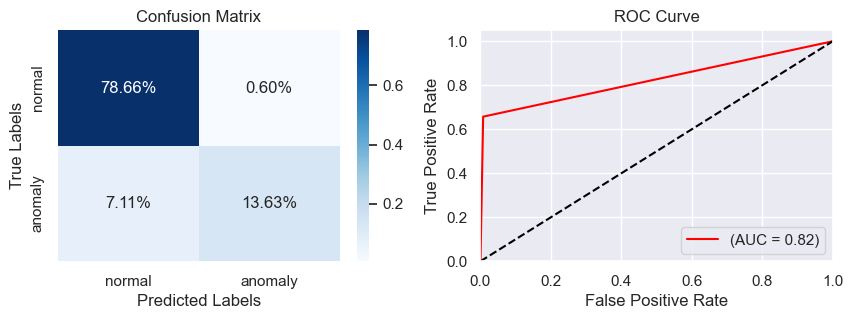

In [29]:
sns.set_theme()
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.heatmap(metrics_data['cm']/np.sum(metrics_data['cm']), annot=True, fmt='.2%', cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')
axs[0].xaxis.set_ticklabels(['normal', 'anomaly'])
axs[0].yaxis.set_ticklabels(['normal', 'anomaly'])
axs[0].set_title('Confusion Matrix')

fpr, tpr, thresholds = roc_curve(y_pipe_test, predictions, pos_label=4)
auc_score = (auc(fpr, tpr))

axs[1].plot(fpr, tpr, label=f'(AUC = {auc_score:.2f})', color='red')
axs[1].plot([0, 1], [0, 1], color='black', linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title(f'ROC Curve')
axs[1].legend(loc="lower right")

plt.plot()
plt.savefig("results/model_results.png", dpi=120)

#### Saving Model

In [61]:
from cloudpickle import dump

In [64]:
model_file = "model/anomaly_detector_pipeline.pkl"

with open(model_file, 'wb') as pkl_file:
    dump(pipe, pkl_file)